# Problem Statement
Analyse the Airbnb and Zillow data for 2 bedroom properties to determine which zipcodes will generate most profit on short term rentals within NY city.

# Importing Required Packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import re
from sklearn.linear_model import LinearRegression
import matplotlib.patches as mpatches
import matplotlib.patches as patches

# Data Preparation

## Zillow Dataset
Let us Start by preparing the zillow dataset

In [2]:
zillow = pd.read_csv('Zip_Zhvi_2bedroom.csv')

In [3]:
zillow.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8946 entries, 0 to 8945
Columns: 262 entries, RegionID to 2017-06
dtypes: float64(213), int64(45), object(4)
memory usage: 17.9+ MB


We can see that zillow dataset contains 8946 rows with 262 columns

Let us filter out the property prices for NY city

In [4]:
def find_newyork(city):
    return re.search('New York',city) != None

In [5]:
zillow_columns = [1,2,6]
zillow_columns += ([i for i in range(7,262)])
zillow_ny = zillow[zillow['City'].apply(find_newyork)].iloc[:,zillow_columns]

In [6]:
zillow_ny.head()

,RegionName,City,SizeRank,1996-04,1996-05,1996-06,1996-07,1996-08,1996-09,1996-10,...,2016-09,2016-10,2016-11,2016-12,2017-01,2017-02,2017-03,2017-04,2017-05,2017-06
0,10025,New York,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1374400,1364100,1366300,1354800.0,1327500,1317300,1333700,1352100,1390000,1431000
2,10023,New York,3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1993500,1980700,1960900,1951300.0,1937800,1929800,1955000,2022400,2095000,2142300
13,10128,New York,14,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1526000,1523700,1527200,1541600.0,1557800,1582900,1598900,1646100,1720500,1787100
14,10011,New York,15,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,2354000,2355500,2352200,2332100.0,2313300,2319600,2342100,2365900,2419700,2480400
20,10003,New York,21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1932800,1930400,1937500,1935100.0,1915700,1916500,1965700,2045300,2109100,2147000


##  A graph to show house price trends over the last 5 years(2012-2017) across various zipcodes
We can see that there are a lot of null values in the earlier years of the dataset. Thus we can plot a trend of house prices across various zipcodes in the latest 5 years of the dataset (2012 - 2017)

In [7]:
dates = list(zillow_ny.columns[-60:])
number_of_dates = range(1,9*(len(dates)),9)
region_names = list(zillow_ny.RegionName)
date_ticks = [dates[i] for i in range(1,61,5)]
number_of_dates_ticks = [number_of_dates[i] for i in range(1,61,5)]

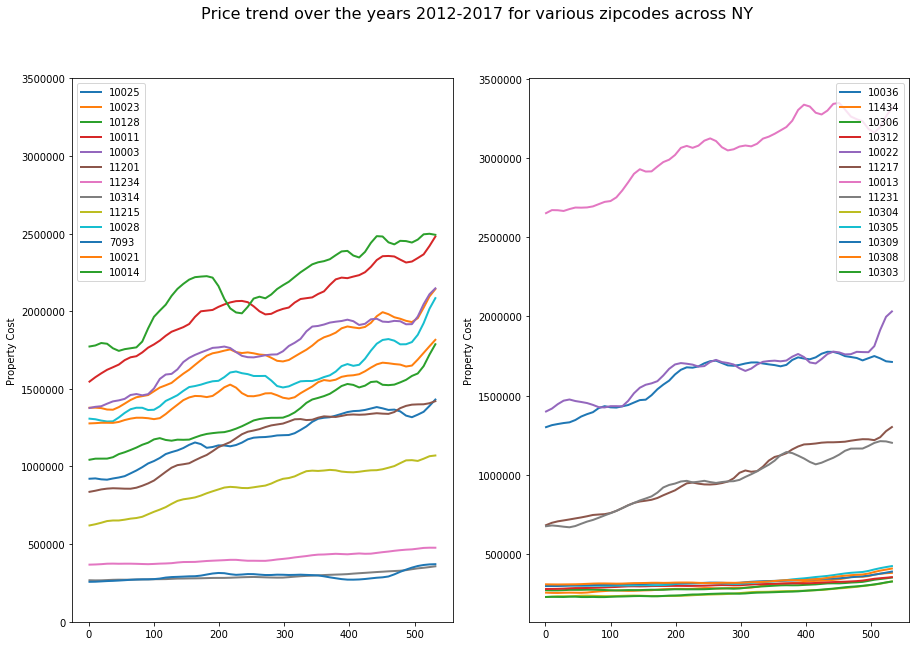

In [8]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(121)
for zipcodes in list(zillow_ny.RegionName)[:len(list(zillow_ny.RegionName))//2]:
    values = zillow_ny[zillow_ny['RegionName'] == zipcodes].iloc[:,-60:].values.tolist()[0]
    ax.plot(number_of_dates, values, label = zipcodes, linewidth=2)
ax.set_ylim(0,3500000)
ax.set_ylabel("Property Cost")
ax.legend()
fig.suptitle("Price trend over the years 2012-2017 for various zipcodes across NY", fontsize = 16)
ax2 = fig.add_subplot(122)
for zipcodes in list(zillow_ny.RegionName)[len(list(zillow_ny.RegionName))//2:]:
    values = zillow_ny[zillow_ny['RegionName'] == zipcodes].iloc[:,-60:].values.tolist()[0]
    ax2.plot(number_of_dates, values, label = zipcodes, linewidth=2)
ax2.set_ylabel("Property Cost")
ax2.legend()

We can infer from the above graph that the property prices show a gradual increase over the years. We can believe that prices will increase in the future. So an investment as soon as possible will save us value.

To get an estimated price for each zipcode, we can select the median of property prices over the last 6 months, 
to avoid any sudden change in property prices in the last few months.

In [9]:
zillow_ny['estimated_price'] = zillow_ny[['2017-01','2017-02','2017-03','2017-04','2017-05','2017-06']].median(axis=1)

In [10]:
zillow_ny.shape

(26, 259)

Our dataset now contains 26 Zipcodes across NY, West NY. We can also go ahead and drop the median prices over time, and only work in the future with the estimated median price of properties.

In [11]:
cols = [i for i in range(3,258)]
zillow_ny.drop(zillow_ny.columns[cols],axis=1,inplace=True)

We have finally narrowed down our zillow dataset to

In [12]:
zillow_ny.head()

,RegionName,City,SizeRank,estimated_price
0,10025,New York,1,1342900.0
2,10023,New York,3,1988700.0
13,10128,New York,14,1622500.0
14,10011,New York,15,2354000.0
20,10003,New York,21,2005500.0


## Airbnb Dataset
Now let us start by preparing our Airbnb dataset
Since zillow provides data for only 2 bedroom houses, we will also select only 2 bedroom listings from the airbnb dataset.

In [13]:
airbnb = pd.read_csv('Listings.csv', low_memory=False)

In [14]:
airbnb.head()

,id,listing_url,scrape_id,last_scraped,name,summary,space,description,experiences_offered,neighborhood_overview,...,review_scores_value,requires_license,license,jurisdiction_names,instant_bookable,cancellation_policy,require_guest_profile_picture,require_guest_phone_verification,calculated_host_listings_count,reviews_per_month
0,7949480,https://www.airbnb.com/rooms/7949480,20170502132028,2017-05-03,City Island Sanctuary relaxing BR & Bath w Par...,Come relax on City Island in our quiet guest r...,"On parle français et anglais, (lire Français c...",Come relax on City Island in our quiet guest r...,none,City Island is a unique sanctuary in New York ...,...,10.0,f,NaN,NaN,f,moderate,t,t,1,1.59
1,16042478,https://www.airbnb.com/rooms/16042478,20170502132028,2017-05-04,WATERFRONT STUDIO APARTMENT,My place is close to Sea Shore. You’ll love my...,(URL HIDDEN),My place is close to Sea Shore. You’ll love my...,none,(URL HIDDEN),...,NaN,f,NaN,NaN,t,flexible,f,f,1,NaN
2,1886820,https://www.airbnb.com/rooms/1886820,20170502132028,2017-05-04,Quaint City Island Community.,Quiet island boating town on Long Island Soun...,"Master bed with queen bed, full bath and offi...",Quiet island boating town on Long Island Soun...,none,Small New England type town in the middle of ...,...,NaN,f,NaN,NaN,f,strict,f,f,1,NaN
3,6627449,https://www.airbnb.com/rooms/6627449,20170502132028,2017-05-05,Large 1 BDRM in Great location,This ground floor apartment is light and airy ...,"We are close to fishing, boating, biking, hors...",This ground floor apartment is light and airy ...,none,City Island is a unique and a hidden gem of Ne...,...,10.0,f,NaN,NaN,f,strict,f,f,1,0.54
4,5557381,https://www.airbnb.com/rooms/5557381,20170502132028,2017-05-04,Quaint City Island Home,"Located in an old sea-shanty town, our home ha...",You won't find a place so close to the city (N...,"Located in an old sea-shanty town, our home ha...",none,"City Island is unique in two ways. First, you ...",...,10.0,f,NaN,NaN,t,moderate,f,f,1,3.63


By going through the definitions of each and every column, the columns that are used from this database include<br>
'id','city','state','zipcode','bedrooms','last_scraped','square_feet','price','weekly_price','monthly_price','cleaning_fee','number_of_reviews','review_scores_rating'<br>
We can also now filter our dataset to contain properties with 2 bedrooms.


In [15]:
airbnb_columns = ['id','city','state','zipcode','bedrooms','last_scraped','square_feet','price','weekly_price','monthly_price','cleaning_fee','number_of_reviews','review_scores_rating']
airbnb = airbnb[airbnb['bedrooms']==2].loc[:,airbnb_columns]

In [16]:
airbnb.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4894 entries, 12 to 40752
Data columns (total 13 columns):
id                      4894 non-null int64
city                    4889 non-null object
state                   4894 non-null object
zipcode                 4832 non-null object
bedrooms                4894 non-null float64
last_scraped            4894 non-null object
square_feet             113 non-null float64
price                   4894 non-null object
weekly_price            1031 non-null object
monthly_price           851 non-null object
cleaning_fee            3928 non-null object
number_of_reviews       4894 non-null int64
review_scores_rating    3874 non-null float64
dtypes: float64(3), int64(2), object(8)
memory usage: 535.3+ KB


In [17]:
airbnb.last_scraped.unique()

array(['2017-05-03', '2017-05-04', '2017-05-05', '2017-05-02'],
      dtype=object)

Here we can actually see that all of our filtered airbnb listings were scrapped in May 2017. Taking this into consideration, I would like to base my analysis, as if we were predicting the most profited zipcodes in May of 2017. So that if a real estate investor would like to invest in a property in May 2017, what zipcodes should he aim for. Thus from the given Zillow dataset we selected the estimated property prices of 2 bedrooms as median of 6 Months untill May 2017.

As we can see the zipcode column name in the zillow dataset is Region Name we will need to change it before we can merge the two datasets

In [18]:
zillow_ny.rename(columns={'RegionName' : 'zipcode'}, inplace=True)
zillow_ny.head()

,zipcode,City,SizeRank,estimated_price
0,10025,New York,1,1342900.0
2,10023,New York,3,1988700.0
13,10128,New York,14,1622500.0
14,10011,New York,15,2354000.0
20,10003,New York,21,2005500.0


Further changing the datatypes of respective column before merging the two dataframes.

In [19]:
airbnb.dropna(subset=['zipcode'],inplace=True)
airbnb['zipcode'] = airbnb['zipcode'].apply(lambda x: str(x).split("-")[0])
airbnb['zipcode'] = pd.to_numeric(airbnb['zipcode'], downcast='integer')

In [20]:
airbnb.head()

,id,city,state,zipcode,bedrooms,last_scraped,square_feet,price,weekly_price,monthly_price,cleaning_fee,number_of_reviews,review_scores_rating
12,9513511,Bronx,NY,10462,2.0,2017-05-03,NaN,$130.00,NaN,NaN,NaN,4,85.0
23,5046189,Bronx,NY,10469,2.0,2017-05-04,NaN,$150.00,NaN,NaN,$75.00,31,95.0
33,4357134,New York,NY,11102,2.0,2017-05-05,NaN,$200.00,NaN,NaN,NaN,0,NaN
36,16027061,Queens,NY,11102,2.0,2017-05-05,NaN,$250.00,NaN,NaN,NaN,0,NaN
38,11301089,Astoria,NY,11105,2.0,2017-05-04,NaN,$79.00,NaN,NaN,$400.00,1,60.0


Now we have successfully prepared Airbnb dataset and Zillow dataset, and are ready to be merged.

# Merging Datasets

In [21]:
final_data = airbnb.merge(zillow_ny,how="inner",on='zipcode')

In [22]:
final_data.head()

,id,city,state,zipcode,bedrooms,last_scraped,square_feet,price,weekly_price,monthly_price,cleaning_fee,number_of_reviews,review_scores_rating,City,SizeRank,estimated_price
0,15910991,Staten Island,NY,10305,2.0,2017-05-03,NaN,$120.00,NaN,NaN,NaN,0,NaN,New York,2087,407900.0
1,17716523,Staten Island,NY,10305,2.0,2017-05-03,NaN,$110.00,NaN,NaN,$70.00,0,NaN,New York,2087,407900.0
2,16155769,Staten Island,NY,10305,2.0,2017-05-05,NaN,$150.00,NaN,NaN,NaN,0,NaN,New York,2087,407900.0
3,13370393,Staten Island,NY,10305,2.0,2017-05-02,NaN,$150.00,NaN,NaN,$65.00,0,NaN,New York,2087,407900.0
4,2611458,Staten Island,NY,10305,2.0,2017-05-04,NaN,$129.00,$780.00,"$2,415.00",$50.00,13,86.0,New York,2087,407900.0


We now have our final merged data which contains 22 Zipcodes from different regions like Manhatten, Queens, Bronx,Staten Island containing 1239 Entries.

In [23]:
print(final_data['city'].unique())
print("Unique Zipcodes",final_data['zipcode'].nunique())

['Staten Island' 'Statenisland ' 'Brooklyn' 'Brooklyn ' nan 'New York'
 'Chelsea, New York' 'NY' 'New York ' 'Park Slope, Brooklyn'
 'Park Slope ,Brooklyn' 'Jamaica ' 'Queens' 'Jamaica']
Unique Zipcodes 22


In [24]:
final_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1239 entries, 0 to 1238
Data columns (total 16 columns):
id                      1239 non-null int64
city                    1238 non-null object
state                   1239 non-null object
zipcode                 1239 non-null int16
bedrooms                1239 non-null float64
last_scraped            1239 non-null object
square_feet             29 non-null float64
price                   1239 non-null object
weekly_price            257 non-null object
monthly_price           180 non-null object
cleaning_fee            1003 non-null object
number_of_reviews       1239 non-null int64
review_scores_rating    971 non-null float64
City                    1239 non-null object
SizeRank                1239 non-null int64
estimated_price         1239 non-null float64
dtypes: float64(4), int16(1), int64(3), object(8)
memory usage: 157.3+ KB


# Data Cleaning

In [25]:
#Setting bedrooms to integer
final_data['bedrooms'] = pd.to_numeric(final_data['bedrooms'], downcast='integer')

In [26]:
#Changing all prices from $price to price:integer
def change_price(price):
    price = str(price)
    return float(''.join(i for i in price if i not in ['$',',']))

In [27]:
for i in ['price','weekly_price','monthly_price','cleaning_fee']:
    final_data[i] = final_data[i].apply(change_price)

Let us analyse daily airbnb prices further to find any outliers

Text(0.5, 0, 'Zipcodes')

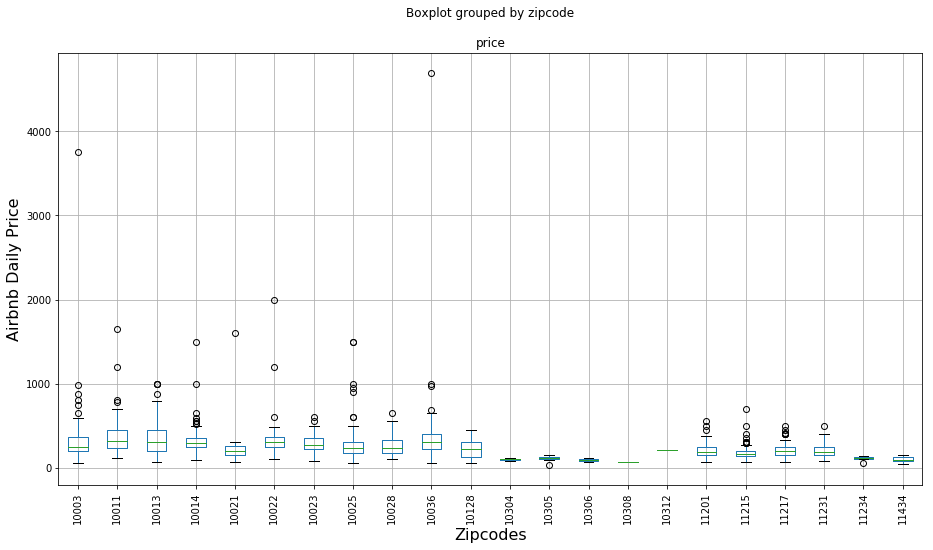

In [28]:
fig_out = plt.figure(figsize=(15,8))
ax1 = fig_out.add_subplot(111)
final_data.boxplot(column='price',by='zipcode',ax=ax1)
ax1.tick_params('x',labelrotation = 90)
ax1.set_ylabel("Airbnb Daily Price",fontsize = 16)
ax1.set_xlabel("Zipcodes", fontsize = 16)

We can definitely see some prices are ridiculously high, let us analyse them further to see what is so special.

In [29]:
final_data[final_data['price'] > 1200]

,id,city,state,zipcode,bedrooms,last_scraped,square_feet,price,weekly_price,monthly_price,cleaning_fee,number_of_reviews,review_scores_rating,City,SizeRank,estimated_price
350,2307885,New York,NY,10011,2,2017-05-03,NaN,1650.0,NaN,NaN,NaN,10,100.0,New York,15,2354000.0
509,2281142,New York,NY,10003,2,2017-05-04,NaN,3750.0,NaN,NaN,NaN,0,NaN,New York,21,2005500.0
578,2243984,New York,NY,10014,2,2017-05-03,NaN,1500.0,NaN,NaN,NaN,0,NaN,New York,379,2476250.0
675,12376888,New York,NY,10036,2,2017-05-03,NaN,4700.0,NaN,NaN,70.0,6,97.0,New York,580,1729150.0
988,2266010,New York,NY,10022,2,2017-05-04,NaN,2000.0,NaN,NaN,NaN,0,NaN,New York,894,1863650.0
1039,5649623,New York,NY,10025,2,2017-05-03,NaN,1500.0,NaN,16500.0,NaN,9,98.0,New York,1,1342900.0
1061,2243769,New York,NY,10025,2,2017-05-03,NaN,1500.0,NaN,NaN,NaN,0,NaN,New York,1,1342900.0
1172,2284454,New York,NY,10021,2,2017-05-04,NaN,1600.0,NaN,NaN,NaN,0,NaN,New York,190,1709950.0


As we can see all these properties are extensive outliers because the prices are not within reasonable standard_deviations of the mean prices of the properties in their zipcodes.<br>
Even if we consider the data to be actually true, we have to consider that they will definitely affect our predictions at later stages in our analysis. Thus we will be dropping these rows from our dataset.

In [30]:
final_data = final_data[final_data['price'] <= 1200]

Let us perform an outlier analysis of the weekly and monthly prices for our dataset

Text(0, 0.5, 'Property Weekly Cost')

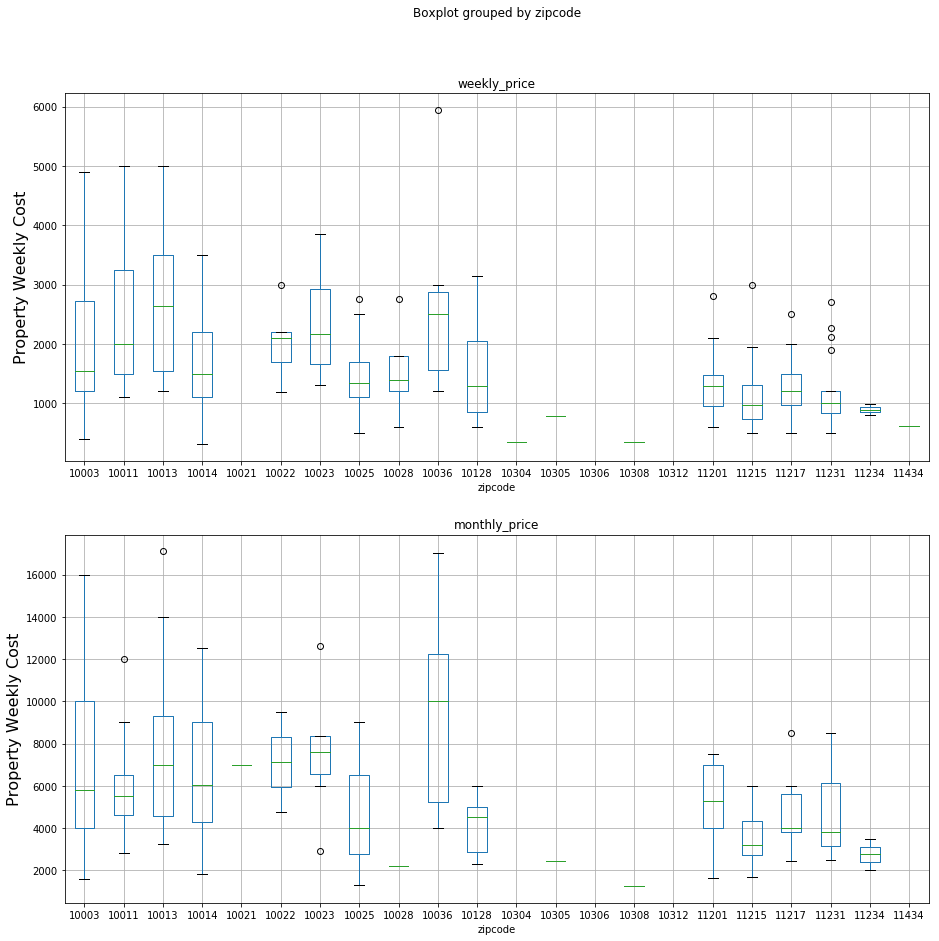

In [31]:
fig_out_2 = plt.figure(figsize=(15,15))

ax1 = fig_out_2.add_subplot(211)
final_data.boxplot(column='weekly_price', by='zipcode', ax=ax1)
ax1.set_ylabel("Zipcodes", fontsize = 16)
ax1.set_ylabel("Property Weekly Cost", fontsize = 16)

ax2 = fig_out_2.add_subplot(212)
final_data.boxplot(column='monthly_price',by='zipcode',ax=ax2)
ax2.set_ylabel("Zipcodes", fontsize = 16)
ax2.set_ylabel("Property Weekly Cost", fontsize = 16)

Although weekly prices and monthly prices have some outliers, we can safely say that they are not totally unreasonable prices.Thus we will not drop them.

In [32]:
#We can go ahead and drop the state and last_scraped column
final_data.drop(columns=['state','last_scraped'], inplace=True)

Let us Handle Missing data in our data set

In [33]:
#For square feet, we can try to get the mean square feet area of properties in a particular zipcode.
final_data['square_feet'] = final_data.groupby('zipcode')['square_feet'].transform(lambda x:x.fillna(x.mean()))
#We can still see that some zipcodes have no data of square feet, which is of about 271 values
#It is a bit confusing to try to predict square feet with such less data, 
#even with the house prices being the same for every zipcode
#So we will decide to drop square feet and cleaning area because there is a logical correlation between the two.
final_data.drop(columns=['square_feet','cleaning_fee'], axis=1, inplace=True)

In [34]:
#Let us assign a region name to 'city' column. We will distinguish our data into 4 main regions across NY.
# Manhatten, Brooklyn, Queens, Staten Island.
def return_regions(df):
    regions = {'Staten Island':'Staten Island', 'Statenisland ':'Staten Island', 'Brooklyn' :'Brooklyn',
 'Chelsea, New York' : 'Manhatten', 'Brooklyn' : 'Brooklyn',
  'Jamaica ':'Queens', 'Queens' : 'Queens', 'Jamaica':'Queens', 'Brooklyn ' : 'Brooklyn', 'Park Slope, Brooklyn':'Brooklyn',
 'Park Slope ,Brooklyn' : 'Brooklyn'}
    if df['city'] in regions:
        return regions[df['city']]
    else:
        return return_zipcode_regions(df['zipcode'])

def return_zipcode_regions(zipcode):
    zipcode_regions = {11217 : 'Brooklyn', 10013 : 'Manhatten', 10011 : 'Manhatten', 10003 : 'Manhatten', 10014 : 'Manhatten', 10036 : 'Manhatten', 10128 : 'Manhatten', 10022 : 'Manhatten', 10025 : 'Manhatten',
       10028 : 'Manhatten', 10021 : 'Manhatten', 10023 : 'Manhatten'}
    if zipcode in zipcode_regions:
        return zipcode_regions[zipcode]
    else:
        return None
final_data['regions'] = final_data.apply(return_regions, axis=1)

In [35]:
#We can now go ahead and drop the city column as well since all regions in our dataset are from New York.
#We can also drop the bedrooms column because we know all of them are 2 bedrooms.
final_data.drop(columns=['city','bedrooms','City'],inplace=True)

As seen in our data, there are no missing values for daily price of an airbnb property.<br>
Let us try to plot the relationship between daily price,weekly price and monthly price, and see if we can predict the missing values

In [36]:
price_1,weekly_price_1 = final_data[final_data['weekly_price'].isna()==False][['price','weekly_price']].values.T.tolist()
price_2,monthly_price_2 = final_data[final_data['monthly_price'].isna()==False][['price','monthly_price']].values.T.tolist()
weekly_price_3,monthly_price_3 = final_data[(final_data['weekly_price'].isna()==False) & (final_data['monthly_price'].isna()==False)][['price','weekly_price']].values.T.tolist() 

Text(0, 0.5, 'Monthly Price')

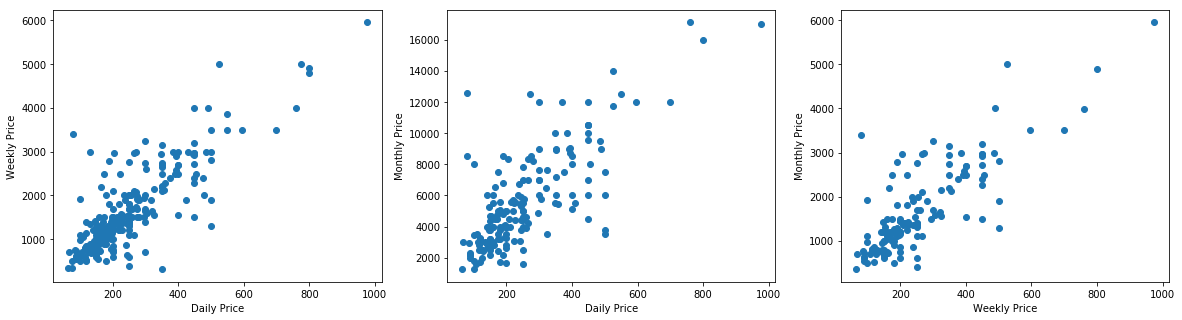

In [37]:
fig1 = plt.figure(figsize=(20,5))
ax1 = fig1.add_subplot(131)
ax1.scatter(price_1, weekly_price_1)
ax2 = fig1.add_subplot(132)
ax2.scatter(price_2,monthly_price_2)
ax3 = fig1.add_subplot(133)
ax3.scatter(weekly_price_3,monthly_price_3)
ax1.set_xlabel('Daily Price')
ax1.set_ylabel('Weekly Price')
ax2.set_xlabel('Daily Price')
ax2.set_ylabel('Monthly Price')
ax3.set_xlabel('Weekly Price')
ax3.set_ylabel('Monthly Price')

We can see that daily price vs weekly price and weekly price vs monthly price almost share a linear relationship.
Although we have too less of data, we will still try to fit a regression line through our data to estimate missing values. Some of this data does not make sense because, the weekly price is much higher than 7 times the daily price, which in turn would provide wrong analysis, because no tenants would end up renting weekly, instead they would just get it for 7 days at daily price. So let us only consider weekly prices that are less than 7 times the daily price to get as much accurate data as possible for the missing values. Similary we will consider the upper bound for the number of weeks in a month to be on the safer side. So we will consider monthly prices that are less than 5 times the price of a week.

In [38]:
price_1, weekly_price_1 = np.array([[i[0],i[1]] for i in list(zip(price_1,weekly_price_1)) if i[1] <= 7*i[0]]).T
weekly_price_3,monthly_price_3 = np.array([[i[0],i[1]] for i in list(zip(weekly_price_3,monthly_price_3)) if i[1] <= 5*i[0]]).T

In [39]:
lm1 = LinearRegression()
lm1.fit(np.array(price_1).reshape(-1,1), np.array(weekly_price_1).reshape(-1,1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [40]:
lm2 = LinearRegression()
lm2.fit(np.array(weekly_price_3).reshape(-1,1), np.array(monthly_price_3).reshape(-1,1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

Text(0, 0.5, 'Monthly Price')

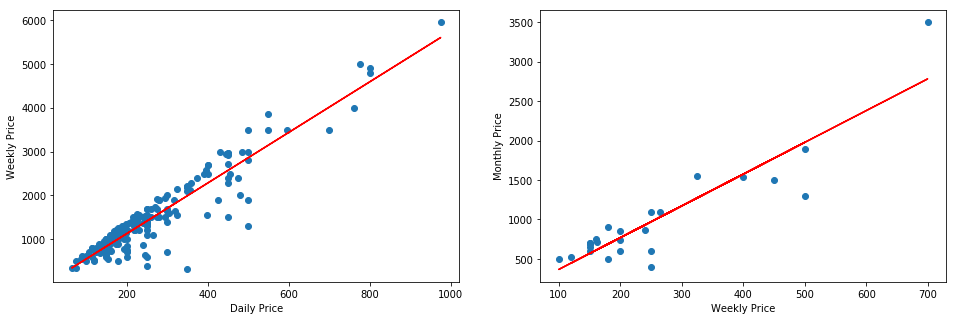

In [41]:
fig3 = plt.figure(figsize=(16,5))
ax1 = fig3.add_subplot(121)
ax1.scatter(price_1,weekly_price_1)
ax1.plot(price_1,lm1.predict(np.array(price_1).reshape(-1,1)), color = 'red')
ax2 = fig3.add_subplot(122)
ax2.scatter(weekly_price_3,monthly_price_3)
ax2.plot(weekly_price_3,lm2.predict(np.array(weekly_price_3).reshape(-1,1)), color='red')
ax1.set_xlabel("Daily Price")
ax1.set_ylabel("Weekly Price")
ax2.set_xlabel("Weekly Price")
ax2.set_ylabel("Monthly Price")

Let us predict our missing values for weekly price

In [42]:
final_data.loc[final_data['weekly_price'].isna(),'weekly_price'] = final_data['price'].apply(lambda x: round(lm1.predict([[x]])[0][0]))

Let us predict our missing values for monthly price

In [43]:
final_data.loc[final_data['monthly_price'].isna(),'monthly_price'] = final_data['weekly_price'].apply(lambda x: round(lm2.predict([[x]])[0][0]))

As we can see we have now finished cleaning the dataset. We have no Null values except in the review_score_rating column.
Given this data it is really hard to estimate our Null values of property review_ratings.

In [44]:
final_data.isna().sum()

id                        0
zipcode                   0
price                     0
weekly_price              0
monthly_price             0
number_of_reviews         0
review_scores_rating    263
SizeRank                  0
estimated_price           0
regions                   0
dtype: int64

#  Exploratory Data Analysis

Let us copy our cleaned dataframe to another dataframe and start our Exploratory Data Analysis

In [45]:
clean_data = final_data.copy(deep=True)
clean_data.head()

,id,zipcode,price,weekly_price,monthly_price,number_of_reviews,review_scores_rating,SizeRank,estimated_price,regions
0,15910991,10305,120.0,662.0,2630.0,0,NaN,2087,407900.0,Staten Island
1,17716523,10305,110.0,604.0,2397.0,0,NaN,2087,407900.0,Staten Island
2,16155769,10305,150.0,835.0,3327.0,0,NaN,2087,407900.0,Staten Island
3,13370393,10305,150.0,835.0,3327.0,0,NaN,2087,407900.0,Staten Island
4,2611458,10305,129.0,780.0,2415.0,13,86.0,2087,407900.0,Staten Island


In [46]:
#Let us start create a colormap for our regions
region_colors = {'Manhatten' : 'red','Brooklyn' : 'blue', 'Queens' : 'green', 'Staten Island' : 'magenta'}
red_patch = mpatches.Patch(color='red', label='Manhatten')
blue_patch = mpatches.Patch(color='blue', label='Brooklyn')
green_patch = mpatches.Patch(color='green', label='Queens')
magenta_patch = mpatches.Patch(color='magenta', label='Staten Island')
l_handle = [red_patch, blue_patch, green_patch, magenta_patch]

## Plot to determine number of zipcodes in each region in NY

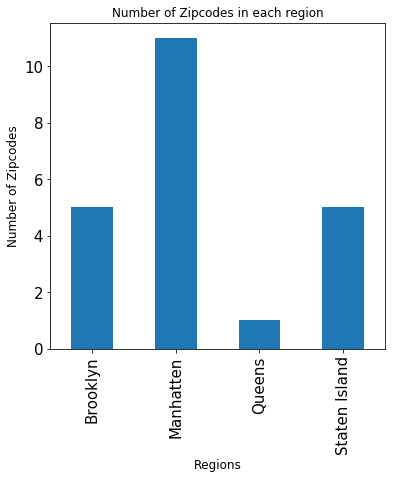

In [47]:
fig4 = plt.figure(figsize=(6,6))
ax1 = fig4.add_subplot(111)
clean_data.groupby('regions').agg({'zipcode' : 'nunique'}).plot(kind = 'bar',ax=ax1, legend=False)
ax1.set_ylabel("Number of Zipcodes", fontsize='large')
ax1.set_xlabel("Regions",fontsize='large')
ax1.set_title("Number of Zipcodes in each region")
ax1.tick_params(axis='both', which='major', labelsize=15)

We have only 1 zipcode to analyse in Queens. But the remaining have atleast 5 zipcodes which gives us ample data to analyse profitable zipcodes.

## Number of Properties in every zipcode

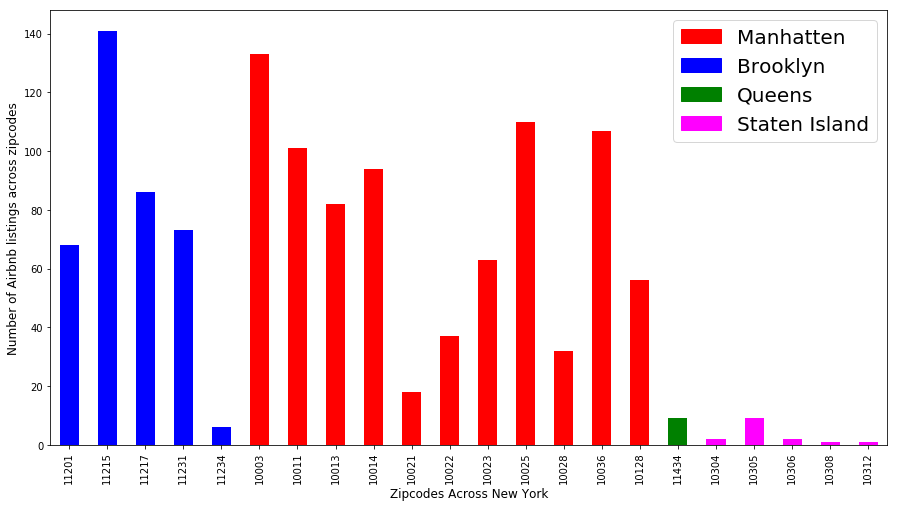

In [48]:
properties_in_zipcode = pd.pivot_table(clean_data[['regions','zipcode','id']], index=['regions','zipcode'], aggfunc=np.count_nonzero)
properties_in_zipcode.reset_index(inplace=True)
fig5 = plt.figure(figsize=(15,8))
ax1 = fig5.add_subplot(111)
properties_in_zipcode.plot('zipcode','id',kind='bar',ax = ax1, color = properties_in_zipcode['regions'].apply(lambda x:region_colors[x]), legend = False)
ax1.set_xlabel("Zipcodes Across New York", fontsize = 'large')
ax1.set_ylabel("Number of Airbnb listings across zipcodes", fontsize = 'large')
ax1.legend(handles = l_handle, prop={'size': 20})

The zipcodes 10308, 10312 have only 1 property listing, 10304,10306 has 2 in our data.
The zipcode 11234 in Brooklyn has only 6.
We can conclude that the data available on Staten Island properties is not quite enough to actually make a decision whether investing in these properties will actually generate profit.
We will analyse the data further.

## Does review count in a specific neighbourhood actually affect the daily price?

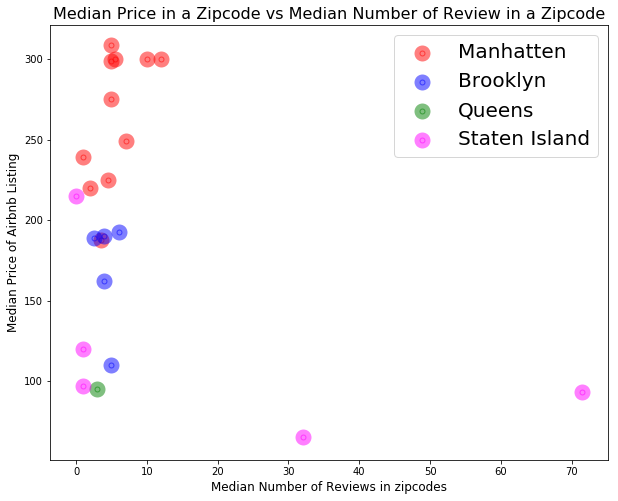

In [49]:
reviewcount_vs_price = clean_data.groupby(['zipcode','regions'], as_index=False).agg({'price' : 'median', 'number_of_reviews' : 'median'})
fig6 = plt.figure(figsize=(10,8))
ax1 = fig6.add_subplot(111)
for region in region_colors:
    ax1.scatter(reviewcount_vs_price[reviewcount_vs_price['regions']==region]['number_of_reviews'],reviewcount_vs_price[reviewcount_vs_price['regions']==region]['price'],label = region,linewidths=10, alpha = 0.5, color = region_colors[region])
ax1.set_ylabel('Median Price of Airbnb Listing', fontsize = 'large')
ax1.set_xlabel('Median Number of Reviews in zipcodes',fontsize = 'large')
ax1.set_title("Median Price in a Zipcode vs Median Number of Review in a Zipcode", fontsize = 16)
ax1.legend(prop={'size': 20})

There seems to be no correlation between the number of reviews on a property and the price decided for the property. It seems to have much more relation with locations.

## Let us check if size rank has a corelation with price of airbnb prices

Text(0.5, 1.0, 'Daily Price of Airbnb vs Size Rank of zipcode')

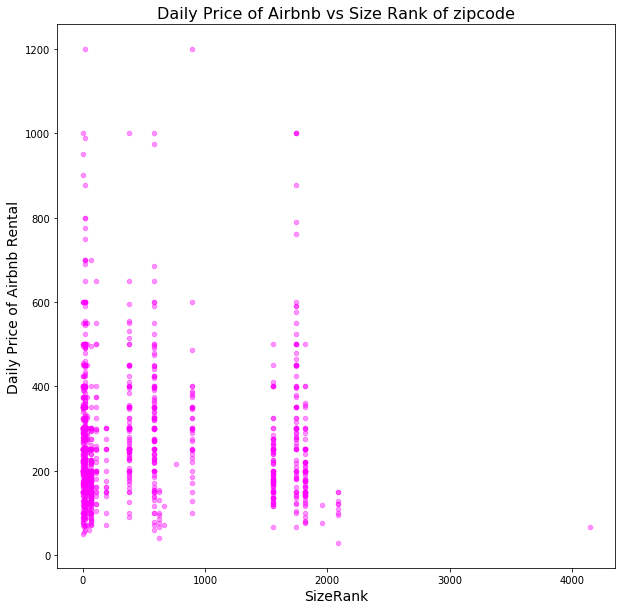

In [50]:
#The lower the sizerank the higher the population
sizerank_vs_price = clean_data[['price','SizeRank']]
fig12 = plt.figure(figsize=(10,10))

ax1 = fig12.add_subplot(111)
sizerank_vs_price.plot('SizeRank','price',color = 'magenta',alpha = 0.4, kind = 'scatter', ax=ax1, legend=False)
ax1.set_xlabel("SizeRank", fontsize = 14)
ax1.set_ylabel("Daily Price of Airbnb Rental", fontsize=14)
ax1.set_title("Daily Price of Airbnb vs Size Rank of zipcode", fontsize=16)

Again there is no relation between population of the zipcode and the price of the airbnb rentals.

## Zillow House Prices across various Zipcodes

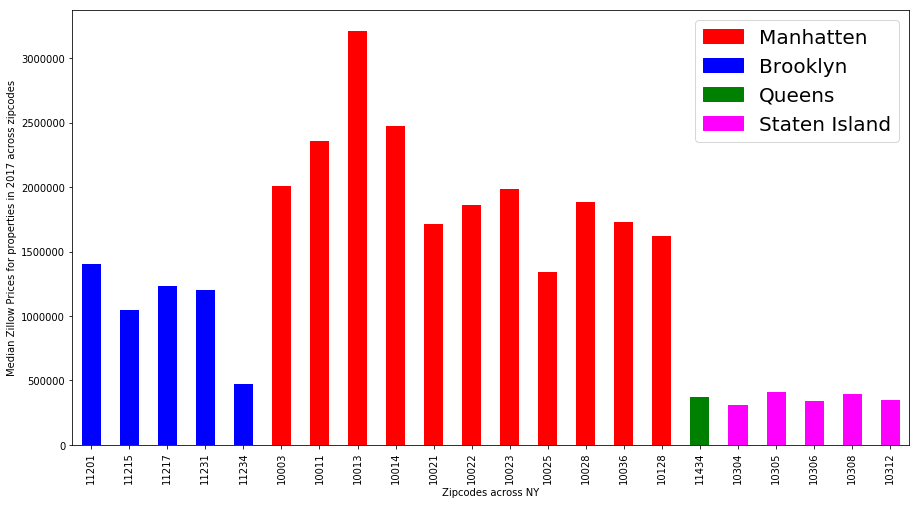

In [51]:
zillowprice_zipcodes = clean_data[['zipcode','regions','estimated_price']].drop_duplicates().sort_values('regions')
zillowprice_zipcodes.sort_values(['regions','zipcode'],ascending = [True,True], inplace=True)
fig7 = plt.figure(figsize=(15,8))
ax1 = fig7.add_subplot(111)
zillowprice_zipcodes.plot('zipcode','estimated_price',kind='bar',ax = ax1, color = zillowprice_zipcodes['regions'].apply(lambda x:region_colors[x]), legend = False)
ax1.set_xlabel("Zipcodes across NY")
ax1.set_ylabel("Median Zillow Prices for properties in 2017 across zipcodes")
ax1.legend(handles = l_handle,prop={'size': 20})

It can be clearly inferred that property prices in Manhatten are extremely high as compared to other neighbourhoods. We will need to visualize other graphs to actually check if such a big investment will actually be profitable with short term rentals.<br>

## Mean airbnb prices across zipcodes

Text(0.5, 1.0, 'Median Airbnb prices for every zipcode')

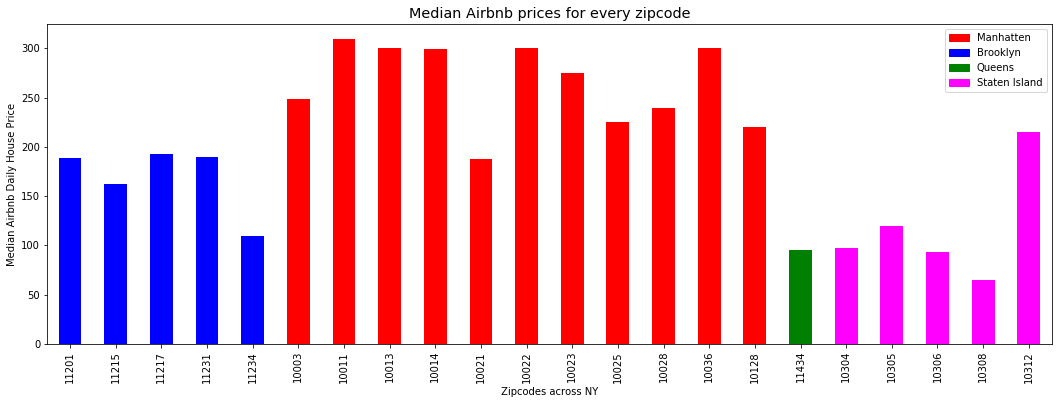

In [52]:
median_airbnb_zipcodes = clean_data.groupby(['zipcode','regions'], as_index=False).agg({'price' : 'median','weekly_price' : 'median','monthly_price' : 'median'})
median_airbnb_zipcodes.sort_values(['regions','zipcode'], ascending = [True,True], inplace = True)
fig8 = plt.figure(figsize=(18,20))
ax1 = fig8.add_subplot(311)
median_airbnb_zipcodes.plot('zipcode','price',kind='bar',ax = ax1, color = median_airbnb_zipcodes['regions'].apply(lambda x:region_colors[x]), legend = False)
ax1.set_xlabel("Zipcodes across NY")
ax1.set_ylabel("Median Airbnb Daily House Price")
ax1.legend(handles = l_handle, prop={'size': 10})
ax1.set_title("Median Airbnb prices for every zipcode", size = 'x-large')

## Plotting median airbnb daily prices vs zillow prices for every zipcode

In [53]:
decisive_plot_1 = clean_data.groupby(['zipcode','regions'],as_index=False).agg({'price' : 'median', 'estimated_price' : 'median'})

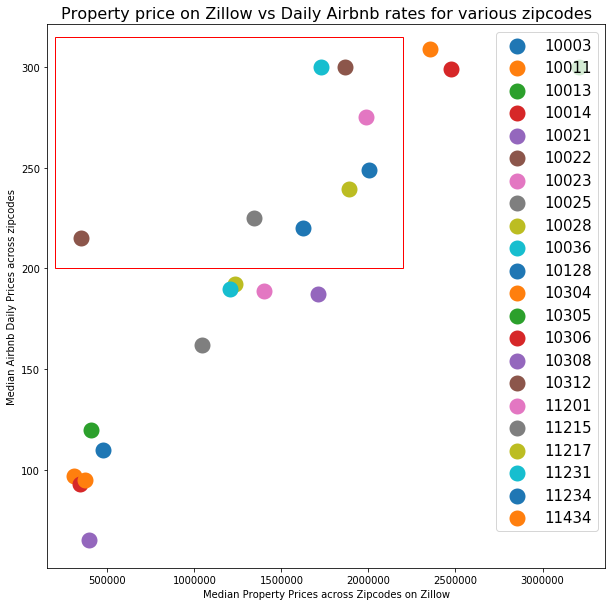

In [54]:
fig_d_1 = plt.figure(figsize=(10,10))
ax1 = fig_d_1.add_subplot(111)
for zipcode in decisive_plot_1['zipcode']:
    ax1.scatter(decisive_plot_1[decisive_plot_1['zipcode'] == zipcode]['estimated_price'],decisive_plot_1[decisive_plot_1['zipcode'] == zipcode]['price'],label = zipcode, linewidth = 10, cmap = 'tab20')

rect = patches.Rectangle((200000,200),2000000,115,linewidth=1,edgecolor='r',facecolor='none')
ax1.add_patch(rect)
ax1.set_xlabel("Median Property Prices across Zipcodes on Zillow")
ax1.set_ylabel("Median Airbnb Daily Prices across zipcodes")
ax1.set_title("Property price on Zillow vs Daily Airbnb rates for various zipcodes", fontsize = 16)
ax1.legend(prop={'size':15})

In this graph we identify a region where the airbnb prices are high, whereas at the same time the investment amount is not too high

Identifying zipcodes within the rectangle

In [55]:
profitable_zipcodes_by_plot_1 = decisive_plot_1[(decisive_plot_1['price'] > 200) & (decisive_plot_1['price'] < 315) & (decisive_plot_1['estimated_price'] < 2200000)][['zipcode','regions']]
profitable_zipcodes_by_plot_1

,zipcode,regions
0,10003,Manhatten
5,10022,Manhatten
6,10023,Manhatten
7,10025,Manhatten
8,10028,Manhatten
9,10036,Manhatten
10,10128,Manhatten
15,10312,Staten Island


We can definitely conclude that 10312 will not be recommended because the data on airbnb listing is very less. We do not have enough data to corroborate our findings.
We will analyse further to see what other zipcodes provide most profit in comparision to the investment.

## Calcuating yearly revenue from airbnb properties

### Assumptions
1 - All properties have a standard occupancy rate of 75% throughout the year.<br>
2 - All properties are booked Daily - 50% of the time, Weekly - 30% of the time, Monthly - 20% of the time.<br>
3 - A Month is considered as 30 days rental period, and a week is considered as 7 days rental period.<br>
###  Estimated Yearly revenue can be calculated as
estimated yearly revenue = $365*\frac{75}{100} (\frac{50}{100}*daily price + \frac{30}{100*7}*weekly price + \frac{20}{100*30}*monthly price)$

In [56]:
def estimate_yearly_revenue(df):
    return round(365 * 0.75 * ((0.5 * df['price']) + (0.3/7 * df['weekly_price']) + (2/300 * df['monthly_price'])))

In [57]:
clean_data['estimated_yearly_revenue'] = clean_data.apply(estimate_yearly_revenue, axis=1)

## Median yearly revenue for airbnb across various zipcodes

Text(0.5, 1.0, 'Median Airbnb Yearly Revenue for every zipcode')

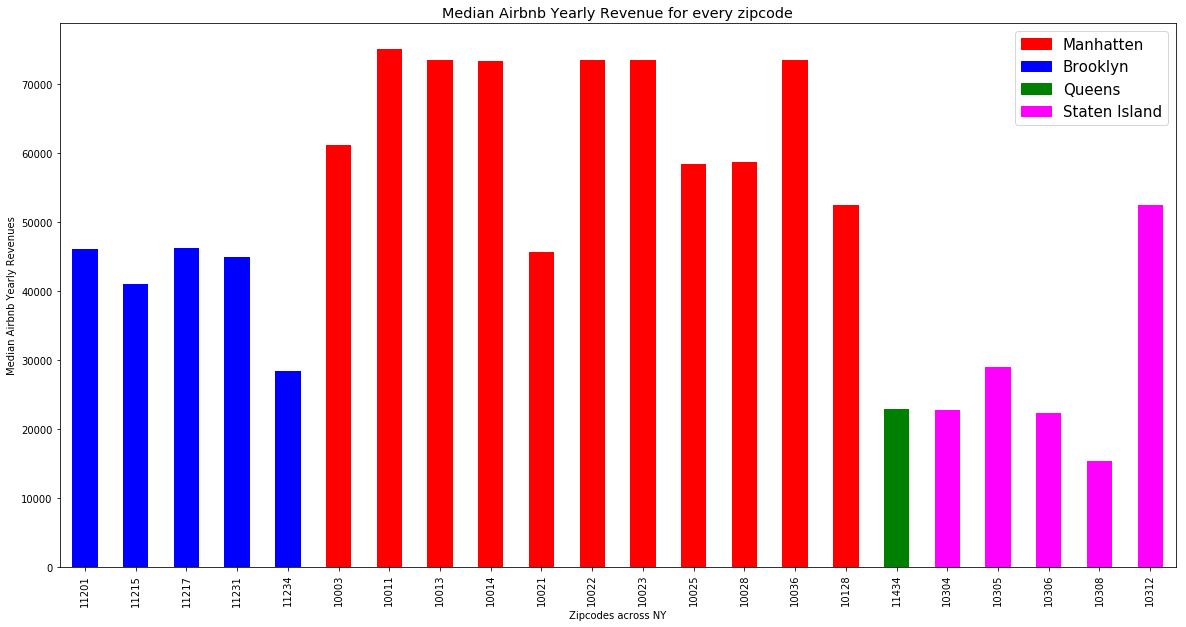

In [58]:
yearly_revenue = clean_data.groupby(['zipcode','regions'], as_index=False).agg({'estimated_yearly_revenue' : 'median'})
yearly_revenue.sort_values(['regions','zipcode'],inplace=True)
fig9 = plt.figure(figsize = (20,10))
ax1 = fig9.add_subplot(111)
yearly_revenue.plot('zipcode','estimated_yearly_revenue',kind='bar',ax = ax1, color = yearly_revenue['regions'].apply(lambda x:region_colors[x]), legend = False)
ax1.set_xlabel("Zipcodes across NY")
ax1.set_ylabel("Median Airbnb Yearly Revenues")
ax1.legend(handles = l_handle, prop={'size': 15})
ax1.set_title("Median Airbnb Yearly Revenue for every zipcode", size = 'x-large')

## plotting the number of years it will take to recover the investment in these zipcodes

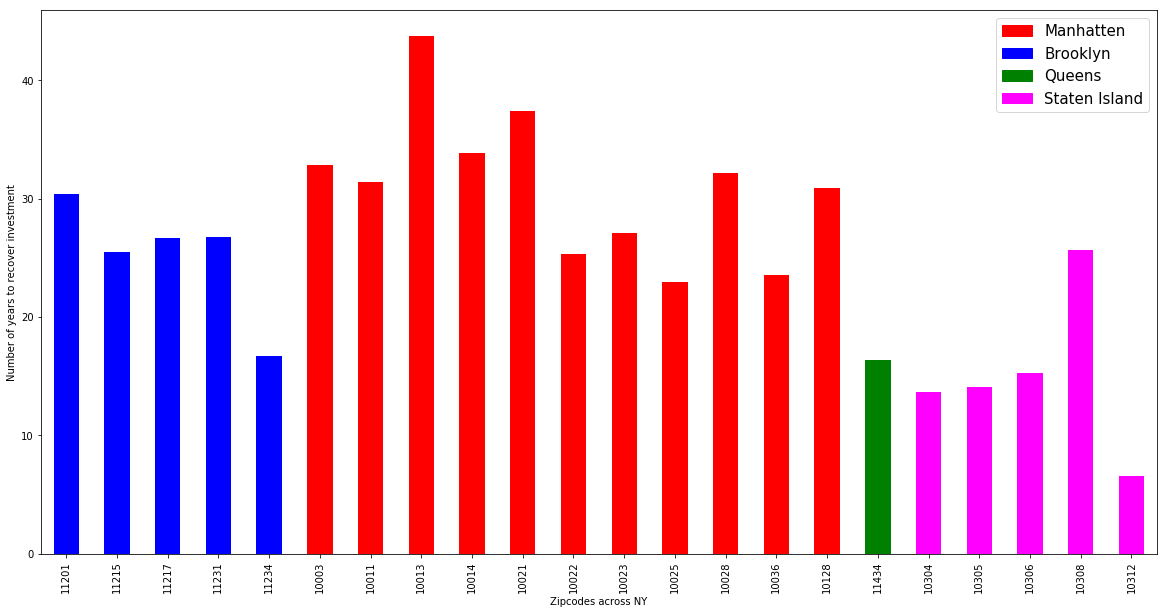

In [59]:
years_to_recover = clean_data.groupby(['zipcode','regions','estimated_price'], as_index=False).agg({'estimated_yearly_revenue' : 'median'})
years_to_recover['years'] = years_to_recover.apply(lambda x : x['estimated_price']/x['estimated_yearly_revenue'], axis = 1)
years_to_recover.sort_values(['regions','zipcode'], ascending = [True,True],inplace=True)
fig10 = plt.figure(figsize = (20,10))
ax1 = fig10.add_subplot(111)
years_to_recover.plot('zipcode','years',kind='bar',ax = ax1, color = years_to_recover['regions'].apply(lambda x:region_colors[x]), legend = False)
ax1.set_xlabel("Zipcodes across NY")
ax1.set_ylabel("Number of years to recover investment")
ax1.legend(handles = l_handle, prop={'size': 15})

From the above plots, we infer that investment in manhatten requires excessive capital and takes on an average about 30 years to recover the investment, but the gains are much higher than the surrounding neighbourhoods. Mean while investment in Staten Island recovers the fastest, but the airbnb data is sufficient enough to corroborate this fact. Brooklyn and Queens are quite similar, on an average they require lesser investment, but the returns are also less compared to manhatten.

## plot a 30 Year summary of our investment for various zipcodes.

In [60]:
years_to_recover['0_years'] = years_to_recover['estimated_price'].apply(lambda x: -x)
years_to_recover['10_years'] = years_to_recover.apply(lambda x: (x['estimated_yearly_revenue']*10) - x['estimated_price'], axis=1)
years_to_recover['15_years'] = years_to_recover.apply(lambda x: (x['estimated_yearly_revenue']*15) - x['estimated_price'], axis=1)
years_to_recover['20_years'] = years_to_recover.apply(lambda x: (x['estimated_yearly_revenue']*20) - x['estimated_price'], axis=1)
years_to_recover['25_years'] = years_to_recover.apply(lambda x: (x['estimated_yearly_revenue']*25) - x['estimated_price'], axis=1)
years_to_recover['30_years'] = years_to_recover.apply(lambda x: (x['estimated_yearly_revenue']*30) - x['estimated_price'], axis=1)
years_to_recover.sort_values(['regions','zipcode'], inplace=True)

Text(0.5, 1.0, 'Summary of various zipcodes after 30 Years')

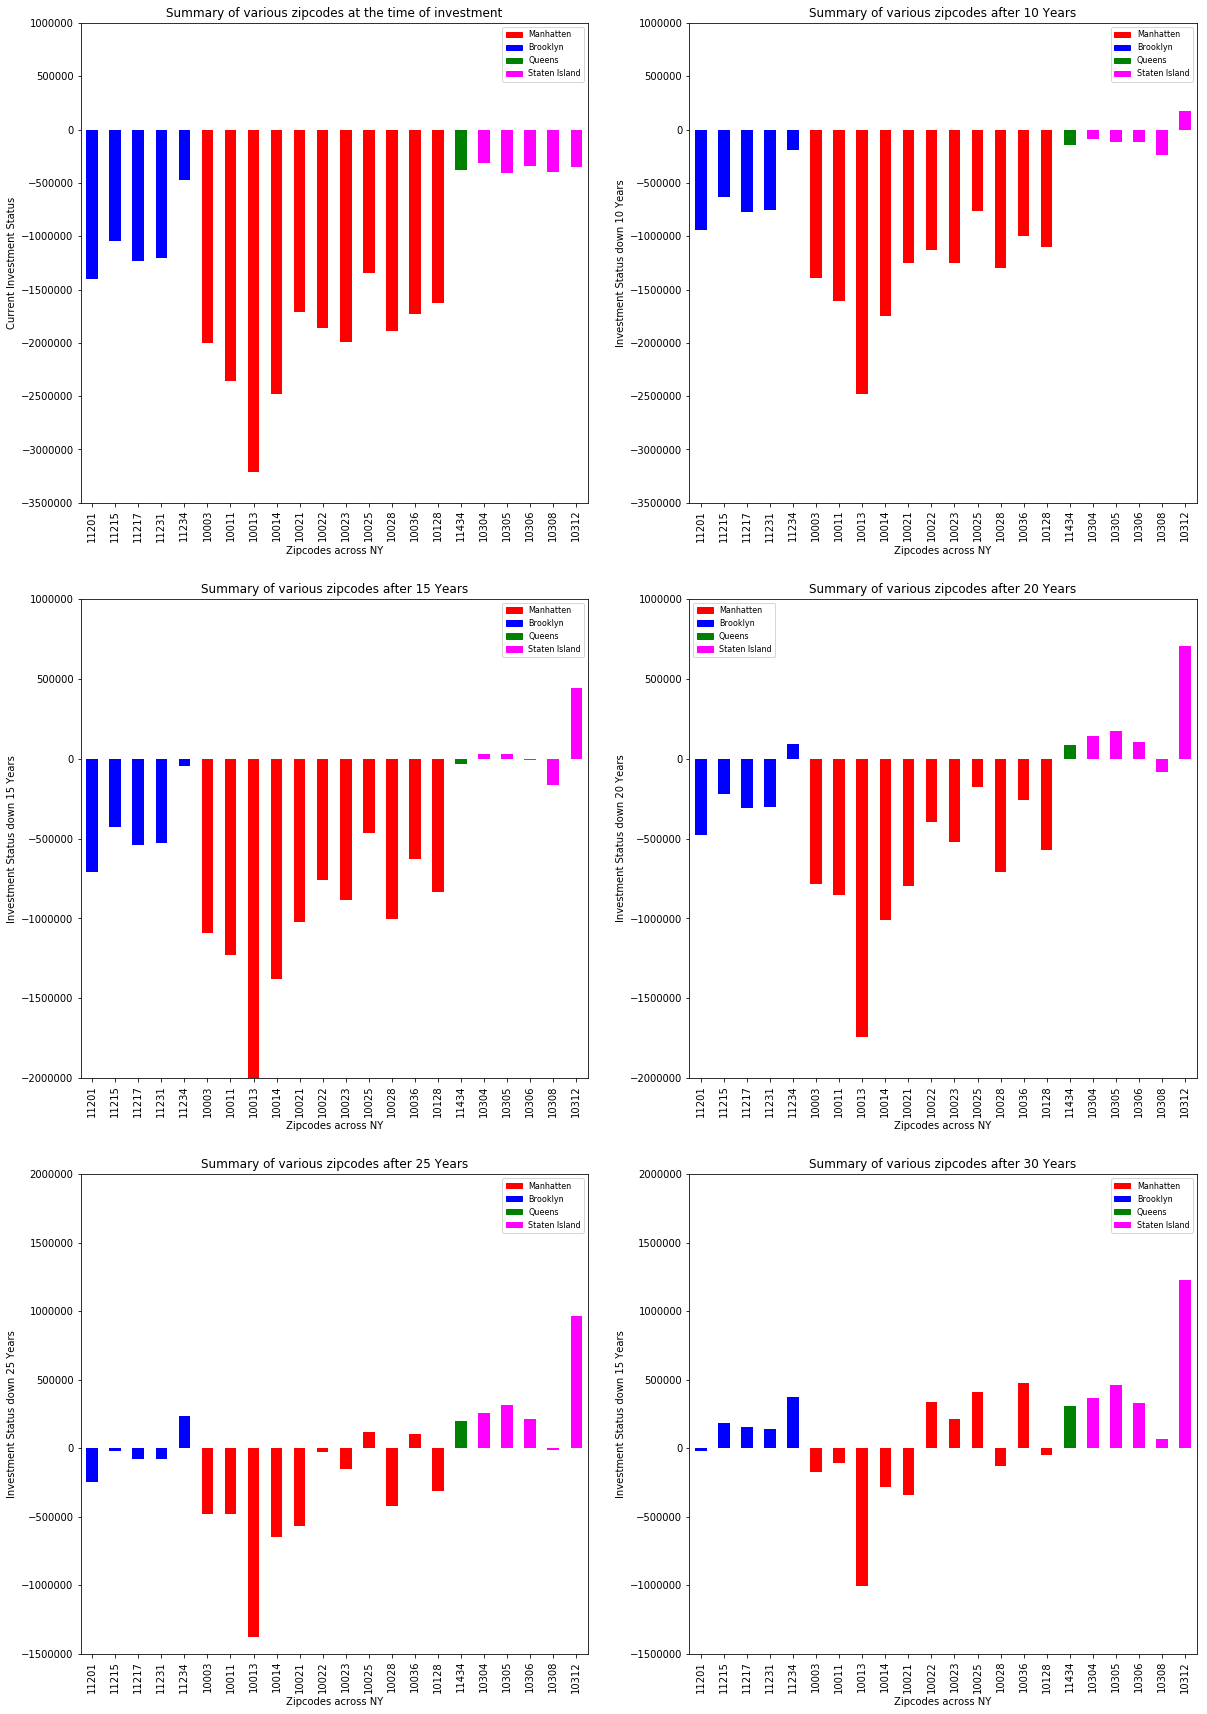

In [61]:
fig11 = plt.figure(figsize=(20,30))

ax1 = fig11.add_subplot(321)
years_to_recover.plot('zipcode','0_years',kind='bar',ax = ax1, color = years_to_recover['regions'].apply(lambda x:region_colors[x]), legend = False)
ax1.set_ylim(-3500000,1000000)
ax1.set_xlabel("Zipcodes across NY")
ax1.set_ylabel("Current Investment Status")
ax1.legend(handles = l_handle, prop={'size': 8})
ax1.set_title("Summary of various zipcodes at the time of investment")

ax2 = fig11.add_subplot(322)
years_to_recover.plot('zipcode','10_years',kind='bar',ax = ax2, color = years_to_recover['regions'].apply(lambda x:region_colors[x]), legend = False)
ax2.set_ylim(-3500000,1000000)
ax2.set_xlabel("Zipcodes across NY")
ax2.set_ylabel("Investment Status down 10 Years")
ax2.legend(handles = l_handle, prop={'size': 8})
ax2.set_title("Summary of various zipcodes after 10 Years")

ax3 = fig11.add_subplot(323)
years_to_recover.plot('zipcode','15_years',kind='bar',ax = ax3, color = years_to_recover['regions'].apply(lambda x:region_colors[x]), legend = False)
ax3.set_ylim(-2000000,1000000)
ax3.set_xlabel("Zipcodes across NY")
ax3.set_ylabel("Investment Status down 15 Years")
ax3.legend(handles = l_handle, prop={'size': 8})
ax3.set_title("Summary of various zipcodes after 15 Years")

ax4 = fig11.add_subplot(324)
years_to_recover.plot('zipcode','20_years',kind='bar',ax = ax4, color = years_to_recover['regions'].apply(lambda x:region_colors[x]), legend = False)
ax4.set_ylim(-2000000,1000000)
ax4.set_xlabel("Zipcodes across NY")
ax4.set_ylabel("Investment Status down 20 Years")
ax4.legend(handles = l_handle, prop={'size': 8})
ax4.set_title("Summary of various zipcodes after 20 Years")

ax5 = fig11.add_subplot(325)
years_to_recover.plot('zipcode','25_years',kind='bar',ax = ax5, color = years_to_recover['regions'].apply(lambda x:region_colors[x]), legend = False)
ax5.set_ylim(-1500000,2000000)
ax5.set_xlabel("Zipcodes across NY")
ax5.set_ylabel("Investment Status down 25 Years")
ax5.legend(handles = l_handle, prop={'size': 8})
ax5.set_title("Summary of various zipcodes after 25 Years")

ax6 = fig11.add_subplot(326)
years_to_recover.plot('zipcode','30_years',kind='bar',ax = ax6, color = years_to_recover['regions'].apply(lambda x:region_colors[x]), legend = False)
ax6.set_ylim(-1500000,2000000)
ax6.set_xlabel("Zipcodes across NY")
ax6.set_ylabel("Investment Status down 15 Years")
ax6.legend(handles = l_handle, prop={'size': 8})
ax6.set_title("Summary of various zipcodes after 30 Years")

## Plotting a graph of number of years to recover vs yearly gains

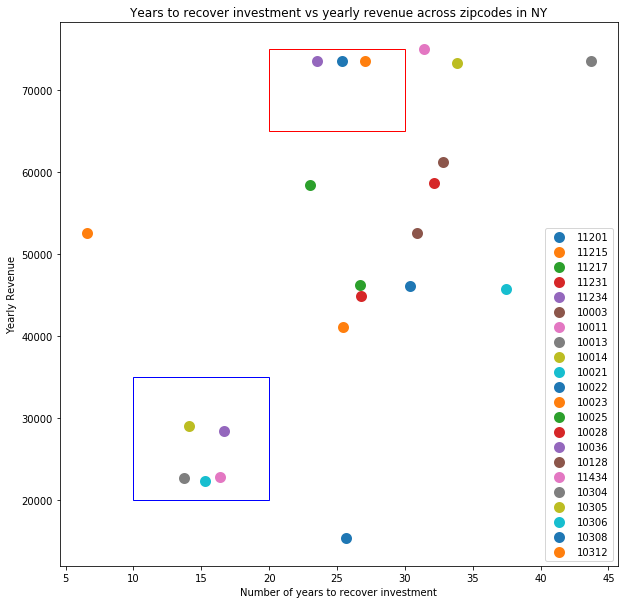

In [62]:
fig_d_2 = plt.figure(figsize=(10,10))
ax1 = fig_d_2.add_subplot(111)
for zipcode in years_to_recover['zipcode']:
    ax1.scatter(years_to_recover[years_to_recover['zipcode'] == zipcode]['years'], years_to_recover[years_to_recover['zipcode'] == zipcode]['estimated_yearly_revenue'], label = zipcode, linewidth = 5)

rect = patches.Rectangle((20,65000),10,10000,linewidth=1,edgecolor='r',facecolor='none')
ax1.add_patch(rect)

rect2 = patches.Rectangle((10,20000),10,15000,linewidth=1,edgecolor='b',facecolor='none')
ax1.add_patch(rect2)

ax1.set_xlabel("Number of years to recover investment")
ax1.set_ylabel("Yearly Revenue")
ax1.set_title("Years to recover investment vs yearly revenue across zipcodes in NY")
ax1.legend()

In this plot we identify two main regions<br>
1(Orange) - Region where the yearly gains from zipcodes are quite high, but at the same time it takes an average of 25 Years to recover the investment.<br>
2(Blue) - Region where the yearly gains are a bit lower than the orange areas but at the same time it takes substantially less amount of time to recover the investment.<br>

Let us identify zipcodes in both our patches

In [63]:
profitable_zipcodes_in_orange = years_to_recover[(years_to_recover['years'] > 20) & (years_to_recover['years'] < 30) & (years_to_recover['estimated_yearly_revenue'] > 65000) & (years_to_recover['estimated_yearly_revenue'] < 75000)][['zipcode','regions']]
profitable_zipcodes_in_blue = years_to_recover[(years_to_recover['years'] > 10) & (years_to_recover['years'] < 20) & (years_to_recover['estimated_yearly_revenue'] > 20000) & (years_to_recover['estimated_yearly_revenue'] < 35000)][['zipcode','regions']]

We would now further analyse zipcodes with the help of previous graphs from both areas to find out the most profitable ones.

In [64]:
profitable_zipcodes_in_orange

,zipcode,regions
5,10022,Manhatten
6,10023,Manhatten
9,10036,Manhatten


In [65]:
profitable_zipcodes_in_blue

,zipcode,regions
20,11234,Brooklyn
21,11434,Queens
11,10304,Staten Island
12,10305,Staten Island
13,10306,Staten Island


In [66]:
profitable_zipcodes_by_plot_1

,zipcode,regions
0,10003,Manhatten
5,10022,Manhatten
6,10023,Manhatten
7,10025,Manhatten
8,10028,Manhatten
9,10036,Manhatten
10,10128,Manhatten
15,10312,Staten Island


# Conclusion

1 - I identify 5 Zipcodes (Manhatten \[10022, 10023, 10036\], Brooklyn \[11234\], Queens\[11434\]) based on sufficient data, recovery years, yearly_revenue, investment_cost and airbnb prices that would generate the most profit.<br>
2 - Looking at all the charts, we can say that if one wants to recover their investment the fastest, investing in Brooklyn and Queens will be the most accurate option. Because these zipcodes require less investment and give a good ROI in the future years.<br>
3 - Investing in Manhatten requires on an average 10 years more than brooklyn and queens to recover the investment but the profit earned in future years is substantially high than brooklyn and queens. Manhatten being the prime hub for tourists results in higher airbnb prices.
4 - Although investing in Staten Island seems exciting due to faster recovery based on the graphs, we have to consider that we do not have enough data for short term rentals in those zipcodes. Thus one should avoid investing in Staten Island until we can find more data on those zipcodes.